In [ ]:
from interpretation.interpret import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Look at performance of the model

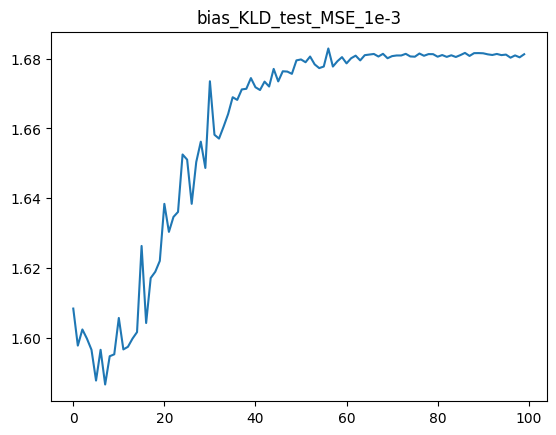

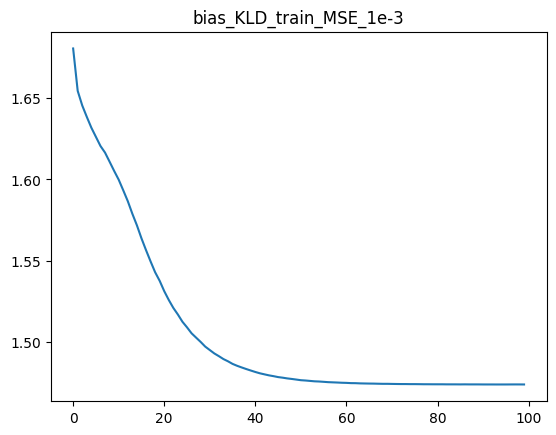

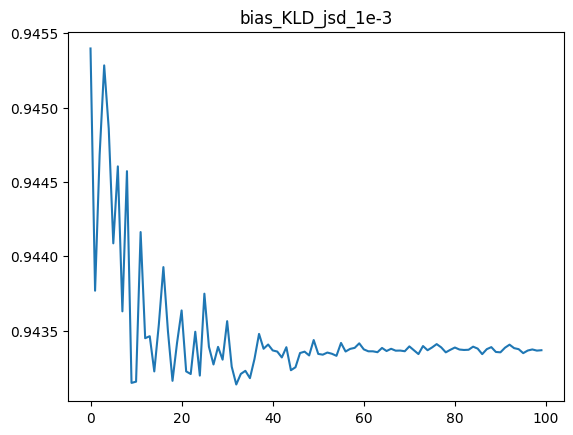

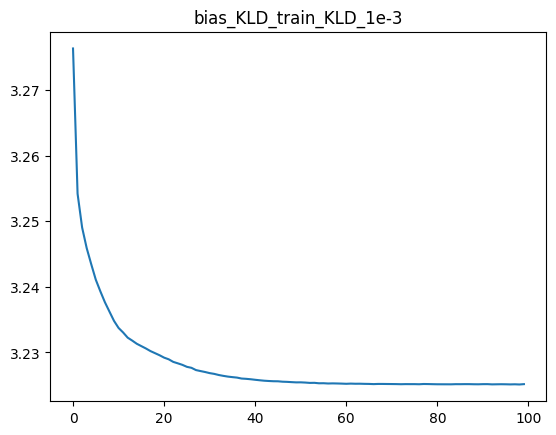

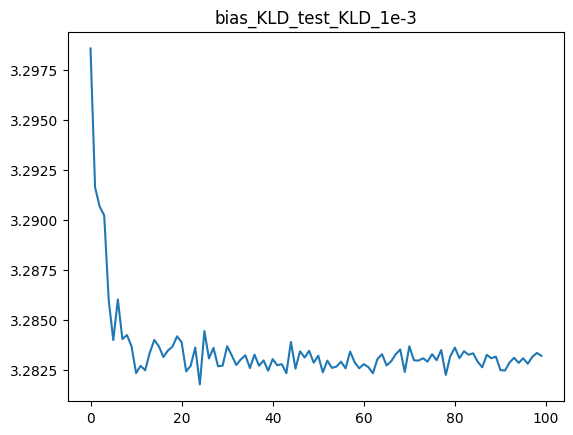

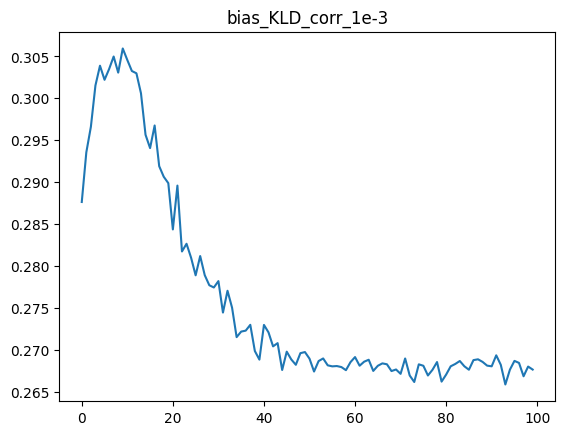

In [ ]:
import glob
import pickle
import matplotlib.pyplot as plt

pkl_files = glob.glob('../results/insertion/bias_KLD_*1e-3.pkl')
skip = '../results/insertion/bias_KLD_model_1e-3.pkl'

for f in pkl_files:
    if f == skip:
        continue

    with open(f, 'rb') as file:
        loss = pickle.load(file)

        plt.plot(loss)
        plt.title(f[21:-4])
        plt.show()

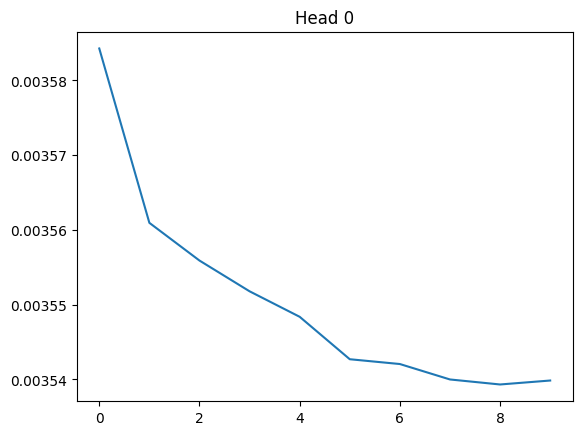

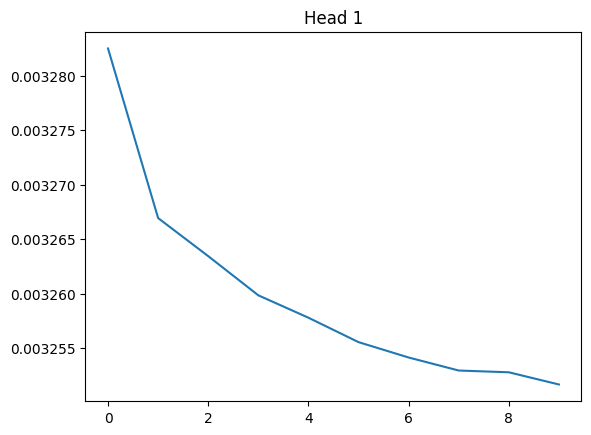

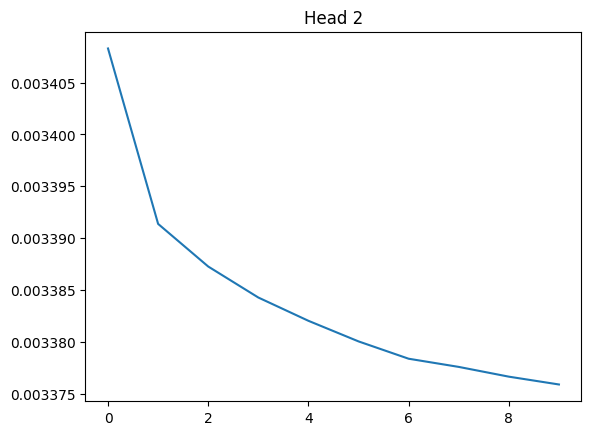

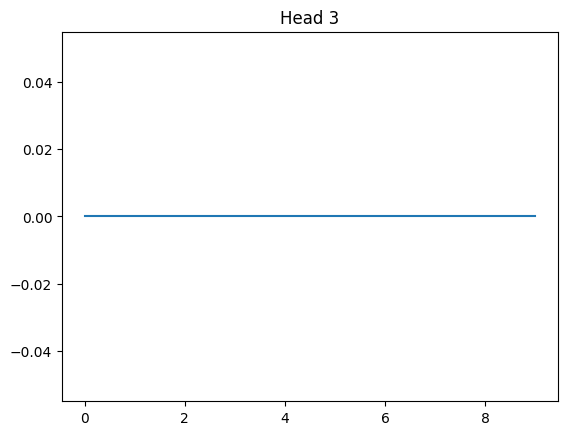

In [245]:
import torch
import matplotlib.pyplot as plt
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

with open('../new/train_KLD_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()


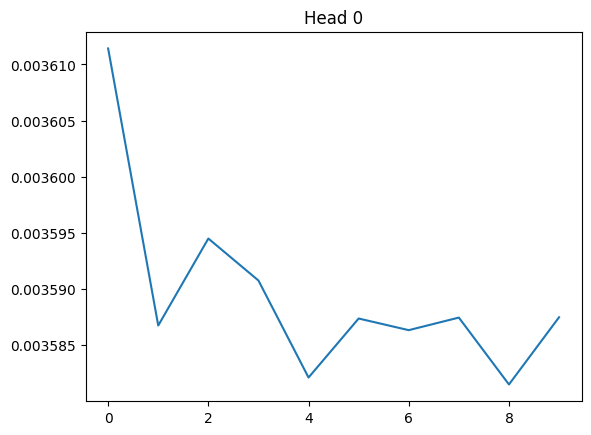

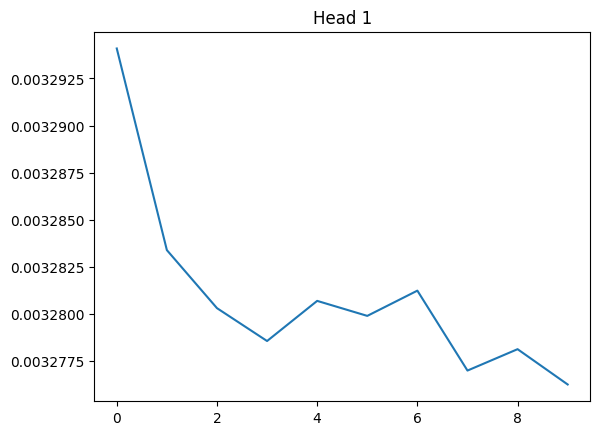

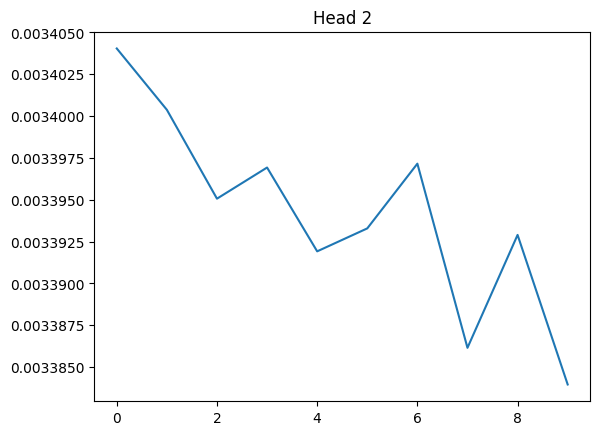

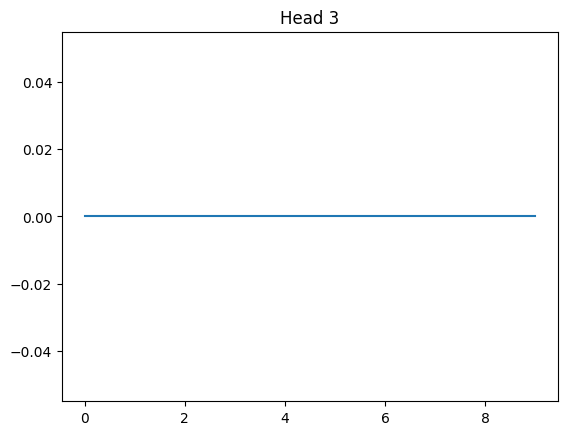

In [246]:
with open('../new/test_KLD_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

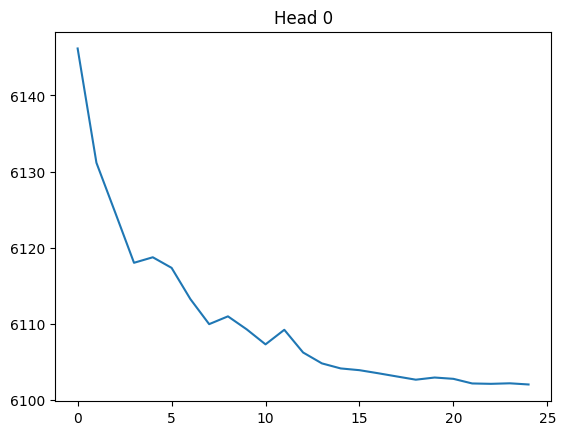

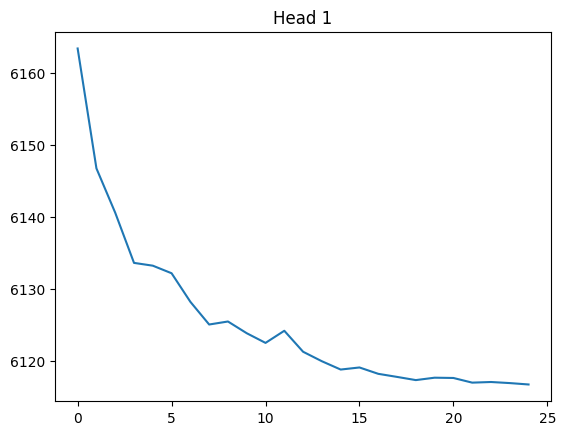

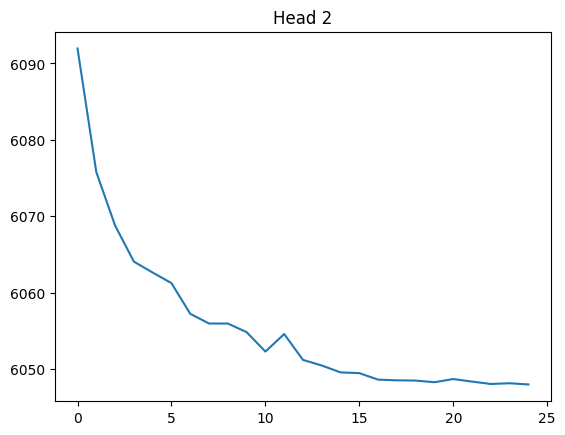

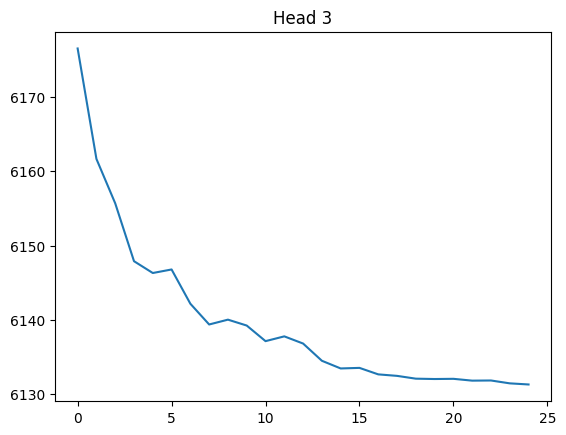

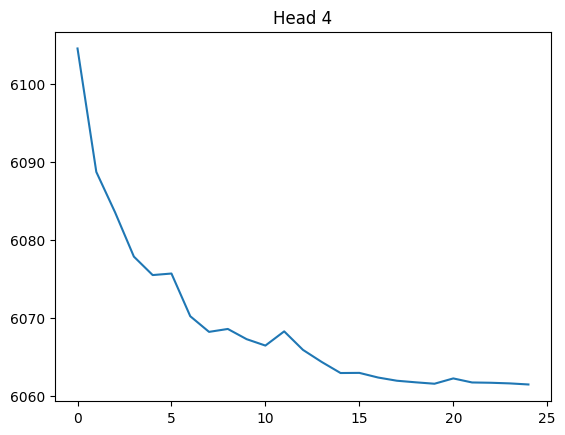

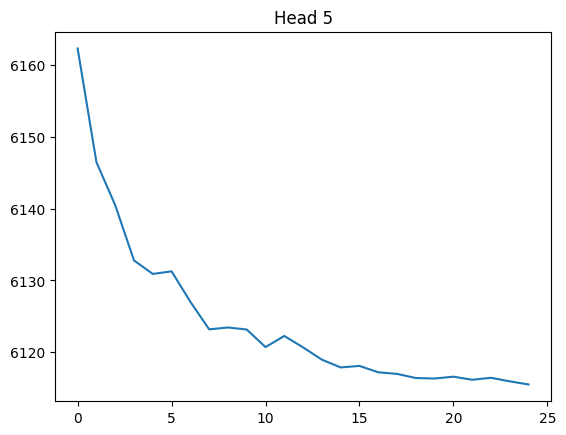

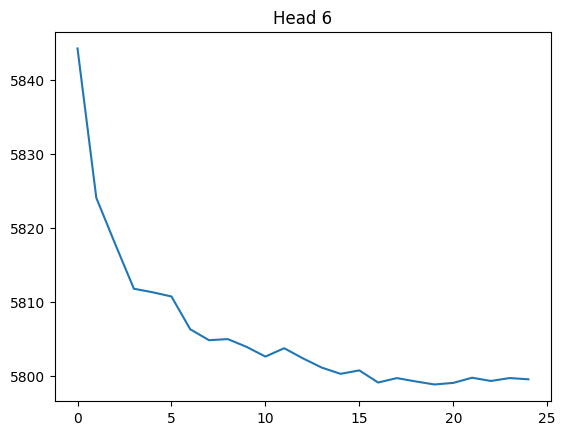

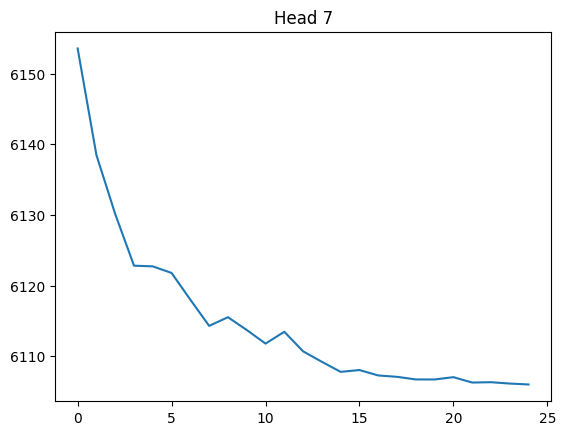

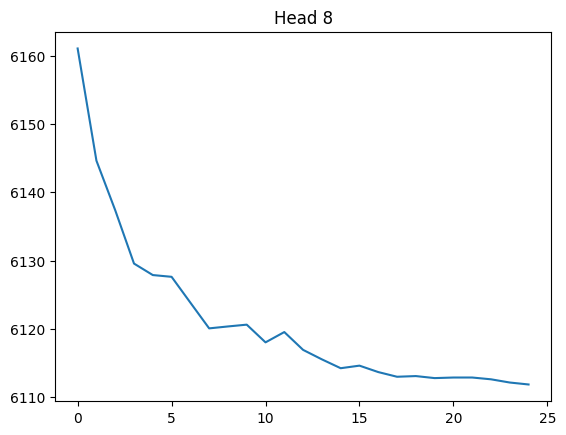

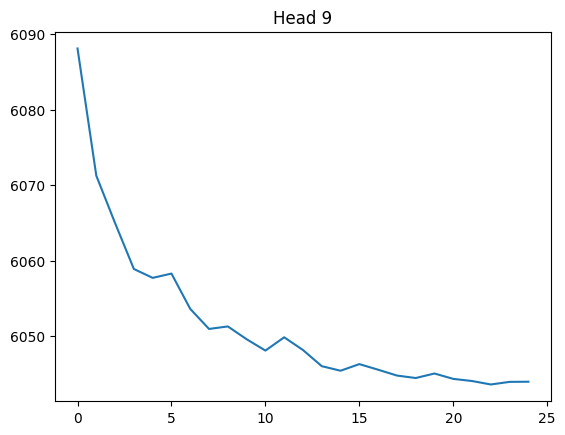

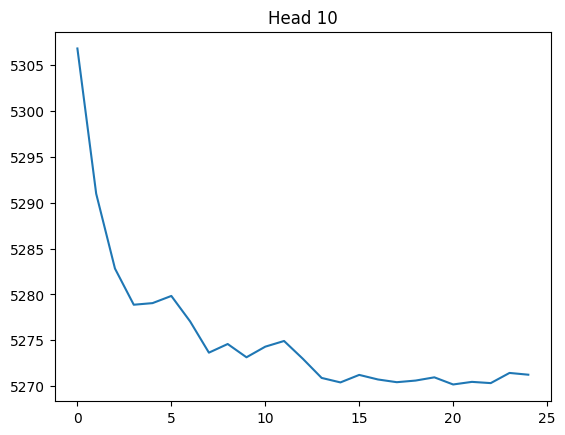

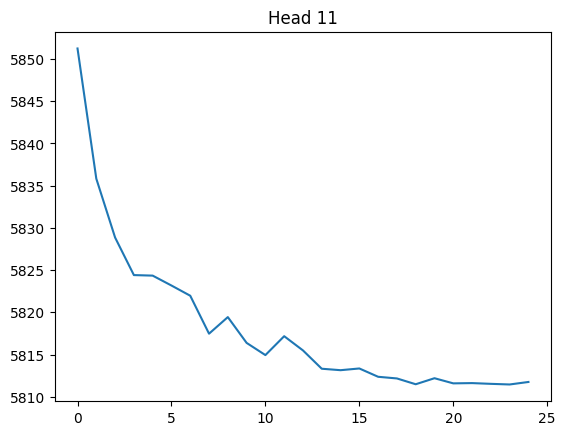

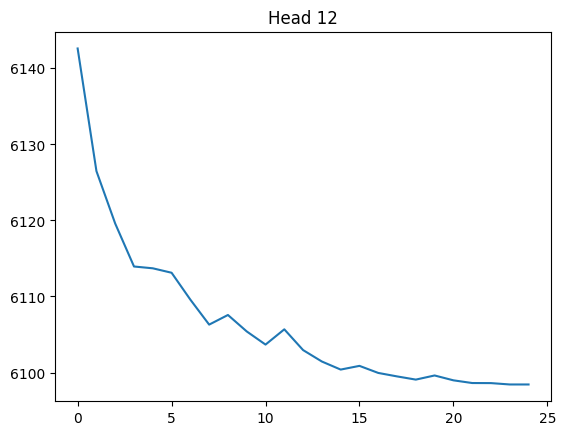

In [ ]:
with open('../results/insertion/MNLL_test_KLD_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

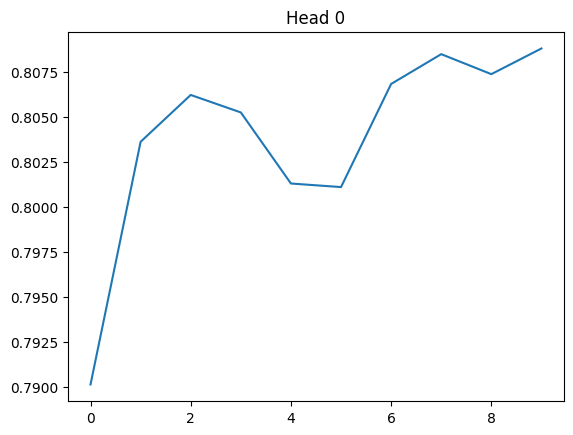

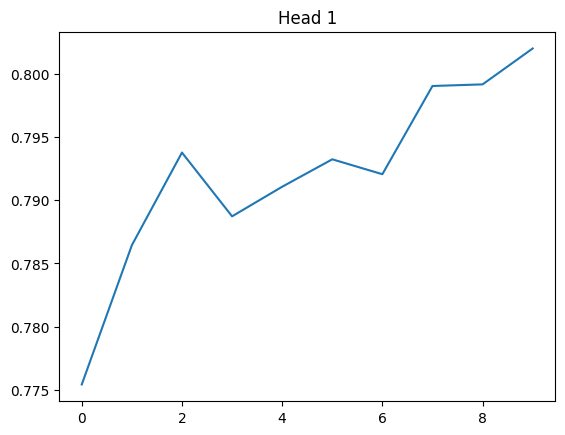

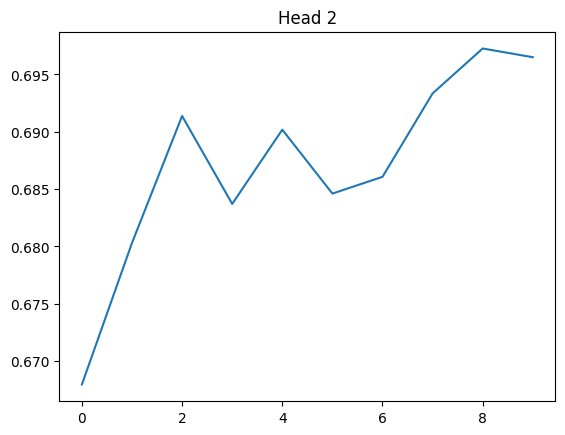

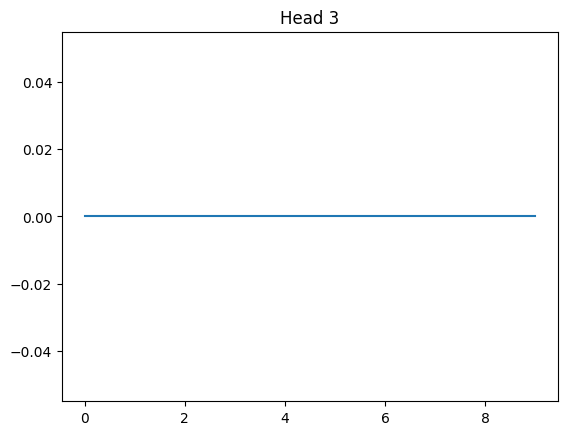

In [247]:
with open('../new/corr_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

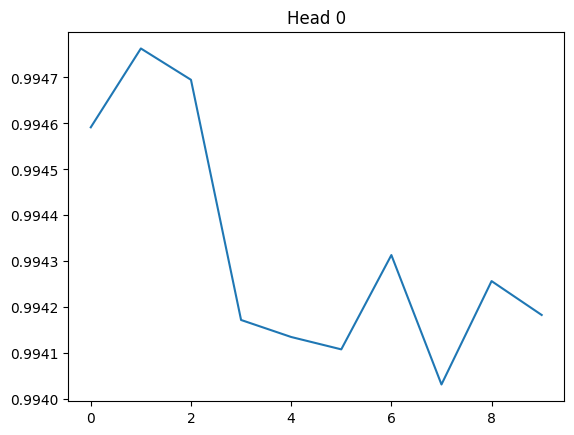

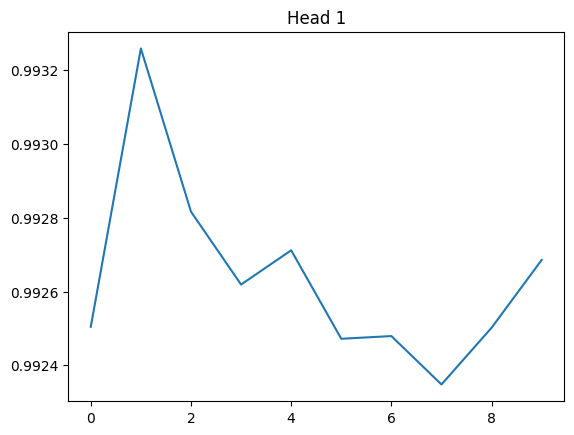

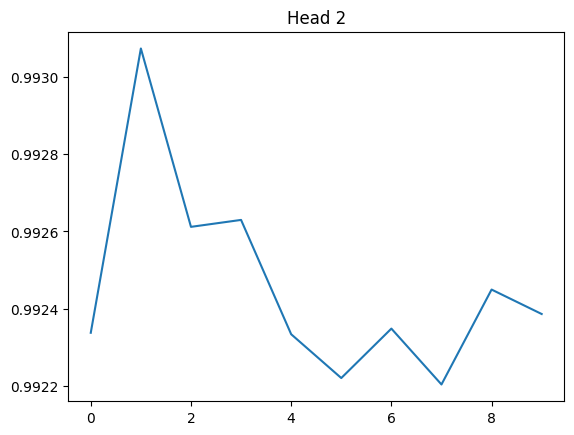

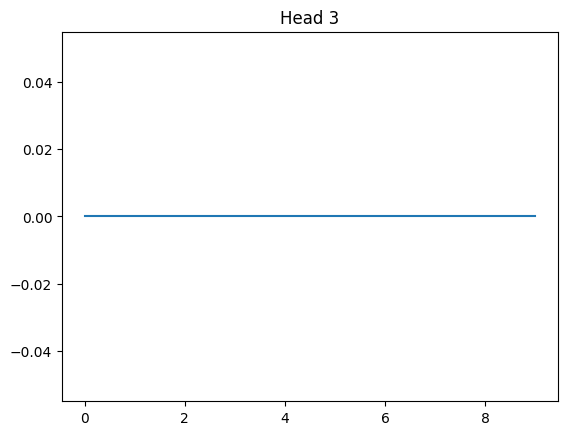

In [248]:
with open('../new/jsd_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

# Create synthetic sequences with TF motif

In [ ]:
import pandas as pd
import numpy as np
import pickle
import math

from data_processing.utils_data_preprocessing import encode_sequence

def generate_motif(motif_file, rng):
    #Load the pw TF motif
    motif = pd.read_excel(motif_file, index_col=0, header=None)  
    motif = motif/motif.sum(axis=0)

    #Generate seq using the prob at each nuclotide

    df_selections = pd.DataFrame(
        data=rng.multinomial(n=1, pvals=(motif).transpose()),
        columns=motif.index).idxmax(axis=1)

    gen_motif = df_selections.str.cat()
        
    return gen_motif

#https://stackoverflow.com/questions/66622025/python-generate-random-dna-sequencing-with-known-gc-percent
def generate_seq(GC_content, motif, len_seq, pred_len):
    #Randomly generate a DNA sequence with given GC content and length
    n = round(GC_content * len_seq)
    GC_nucl = list(set('GC'))
    AT_nucl = list(set('AT'))

    seq = [np.random.choice(GC_nucl) for _ in range(n)]
    seq += [np.random.choice(AT_nucl) for _ in range(len_seq - n)]
    np.random.shuffle(seq)
    seq = ''.join(seq)

    #Insert randomly motif in sequence
    insert_idx = int(np.random.randint(low=(math.ceil(len_seq - pred_len)/2), 
                                       high = (math.ceil(len_seq - pred_len)/2) + pred_len, size=1))
    seq = seq[:insert_idx] + motif + seq[insert_idx:]

    return seq, insert_idx
    

CTCF_file = '../data/CTCF.xlsx'
MYOD_file = '../data/MYOD.xlsx'
Tn5_file = '../data/Tn5.xlsx'

rng = np.random.default_rng()

motif = generate_motif(CTCF_file, rng)
seq, insert_idx = generate_seq(0.41, motif, 4096 - len(motif), 1024)

print(insert_idx)
(seq.count('G') + seq.count('C'))/len(seq)


2206


0.41015625

In [ ]:
motif_files, n = ['../data/CTCF.xlsx', '../data/MYOD.xlsx', '../data/Tn5.xlsx'], 2
rng = np.random.default_rng(42)

syn_seq, idx_motif = [], []
for f in motif_files:
    for _ in range(n):
        motif = generate_motif(f, rng)
        seq, idx = generate_seq(0.41, motif, 4096 - len(motif), 1024)

        syn_seq.append(seq)
        idx_motif.append(idx)

with open('../data/synthetic_sequences.pkl', 'wb') as file:
        pickle.dump(syn_seq, file)

with open('../data/synthetic_sequences_idx.pkl', 'wb') as file:
        pickle.dump(idx_motif, file)        


# Compute importance score of nucleotide using shap

In [254]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
from interpretation.interpret import compute_importance_score_c_type, visualize_sequence_imp
from models.models import CATAC2
import torch

In [292]:
path_model = '../new/model_1e-3.pkl'
path_seq = '../data/synthetic_sequences.pkl'

all_c_type = ['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CATAC2(nb_conv=8, nb_filters=64, first_kernel=21, 
                      rest_kernel=3, out_pred_len=1024, 
                      nb_pred=4)
        
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))

seq, shap_score, proj_score = compute_importance_score_c_type(model, path_seq, device, "Somite", all_c_type)

/Applications/anaconda3/envs/LeKira/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([6, 11, 4096])


In [296]:
proj_score.shape

torch.Size([6, 11, 4096])

In [293]:
with open('../data/synthetic_sequences_idx.pkl', 'rb') as file:
    idx = pickle.load(file)

idx

[1710, 2206, 2499, 2279, 2469, 1826]

Scores for example 0


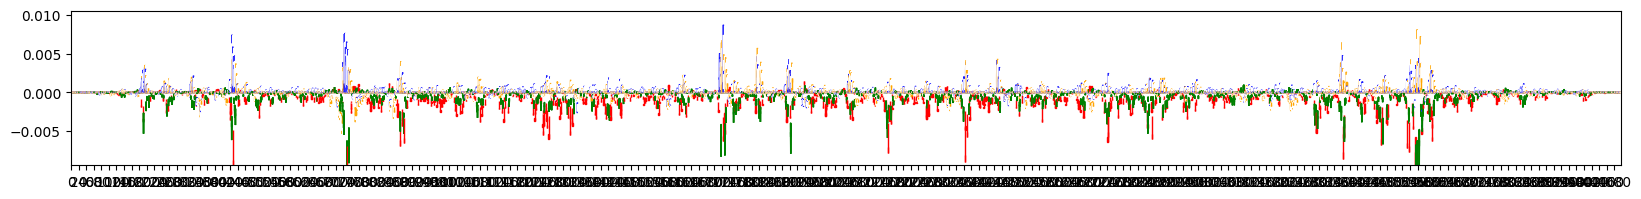

Scores for example 1


In [299]:
visualize_sequence_imp(proj_score[[0,1],:4,:] ,0, 4096)


Scores for example 0


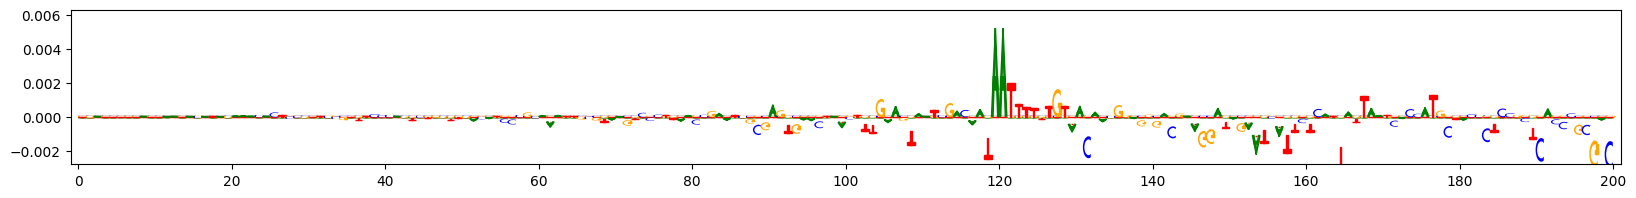

Scores for example 1


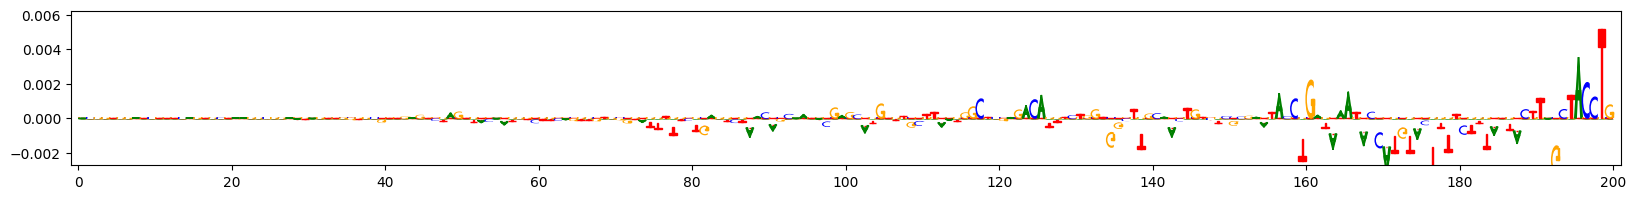

In [ ]:
visualize_sequence_imp(proj_score[[0,1],:,:] ,0, 200)


Scores for example 0


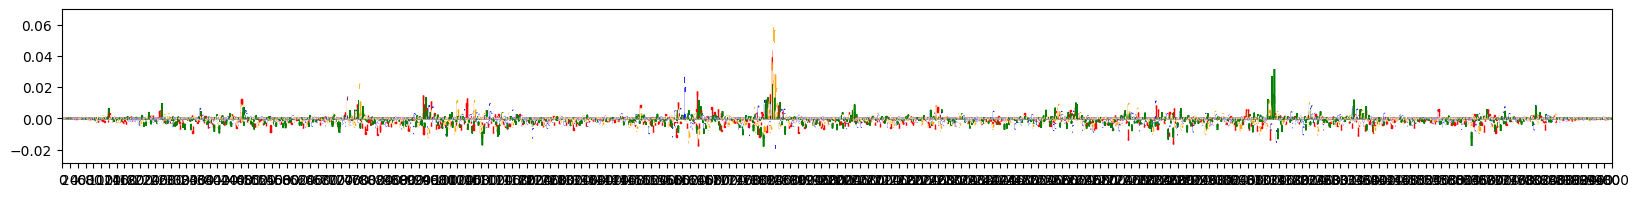

Scores for example 1


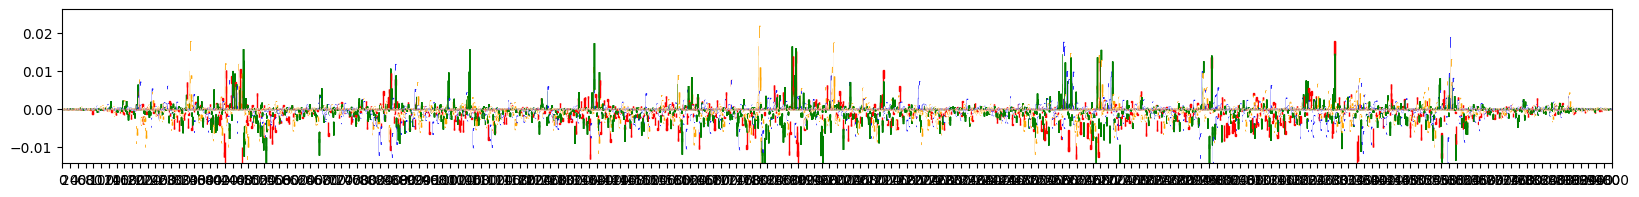

Scores for example 2


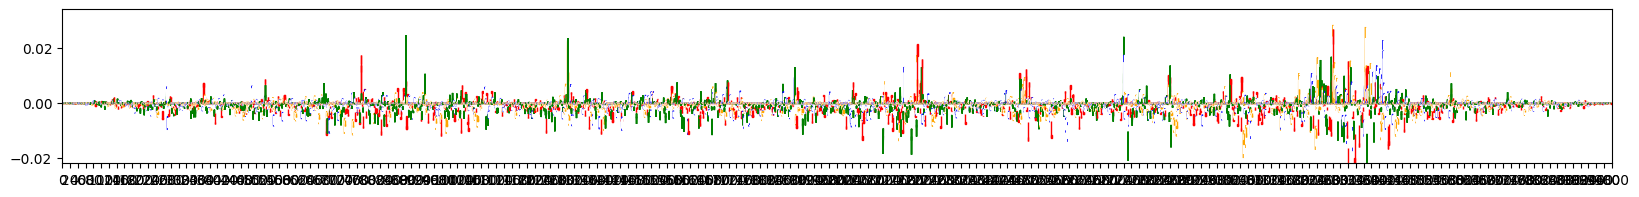

Scores for example 3


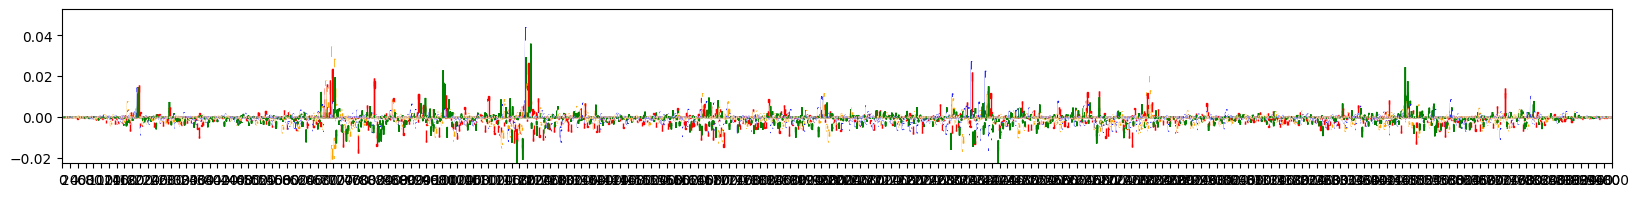

Scores for example 4


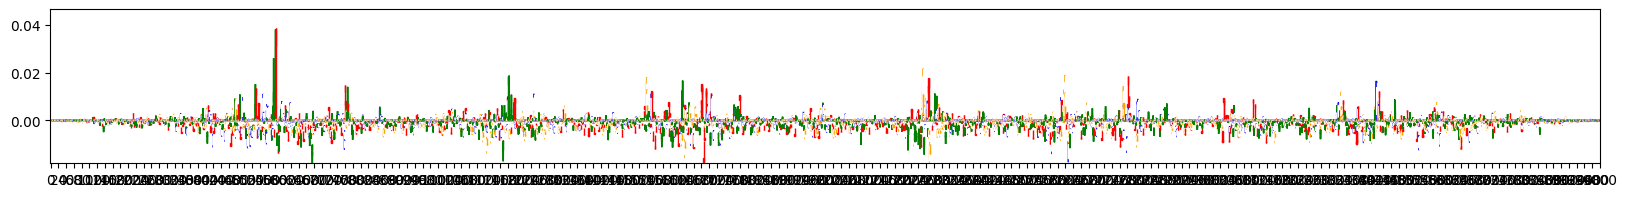

Scores for example 5


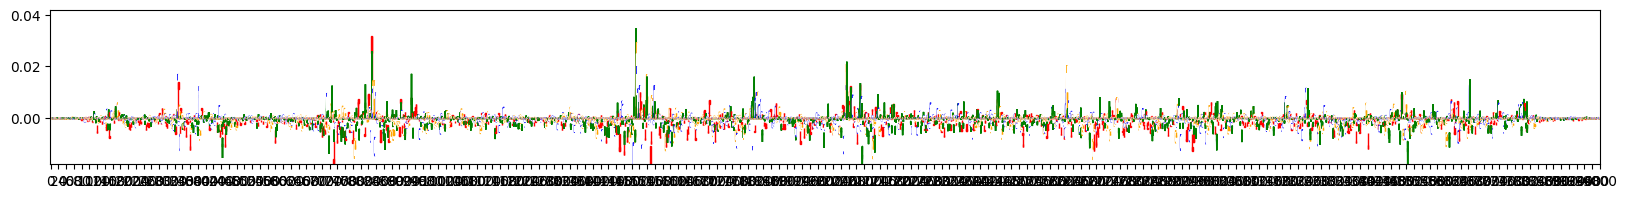

In [ ]:
visualize_sequence_imp(proj_score ,0, 4000)


In [ ]:
model()

# Number of parameters

In [ ]:
from models.models import BPNet, CATAC

biasModel =  BPNet(nb_conv=8, nb_filters=64)
model = CATAC(nb_conv=8, nb_filters=64, first_kernel=21, 
                      rest_kernel=3, profile_kernel_size=75, out_pred_len=1024, 
                      nb_pred=24, nb_cell_type_CN = 0)

print("Main model")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Bias model")
print(sum(p.numel() for p in biasModel.parameters() if p.requires_grad))

Main model
208688
Bias model
96770


# Look at track predictions

In [ ]:
import pickle
import matplotlib.pyplot as plt
import pandas
import numpy as np

with open('../results/pred.pkl', 'rb') as file:
    pred = pickle.load(file)

with open('../results/true.pkl', 'rb') as file:
    true = pickle.load(file)

pred

tensor([[0.0314, 0.1550, 0.1321,  ..., 0.1957, 0.1467, 0.0360],
        [0.0769, 0.2715, 0.2097,  ..., 0.3285, 0.1148, 0.0298],
        [0.0367, 0.0179, 0.0049,  ..., 0.0044, 0.0056, 0.0106],
        [0.0633, 0.0443, 0.0351,  ..., 0.0333, 0.2835, 0.3710],
        [0.0045, 0.0054, 0.0021,  ..., 0.0999, 0.0303, 0.0032]])

In [ ]:
true = true[true.pseudo_bulk == "D12Neuronal"]
true

,0,pseudo_bulk
7:2499849-2500856,"[0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, ...",D12Neuronal
17:64458628-64459743,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D12Neuronal
9:112305148-112306129,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D12Neuronal
1:53862300-53863169,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D12Neuronal
14:102848954-102849980,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",D12Neuronal


<BarContainer object of 1024 artists>

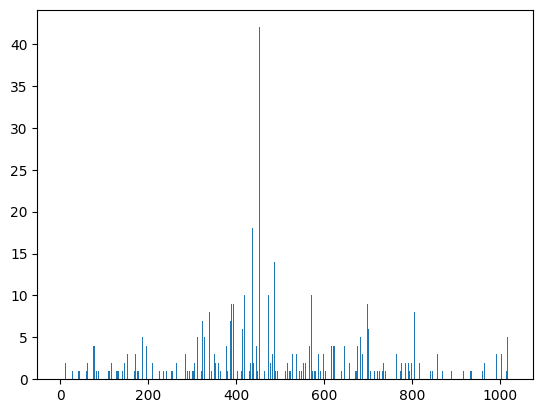

In [ ]:
plt.bar(x = np.arange(0,1024), height = true.iloc[0,0])

<BarContainer object of 1024 artists>

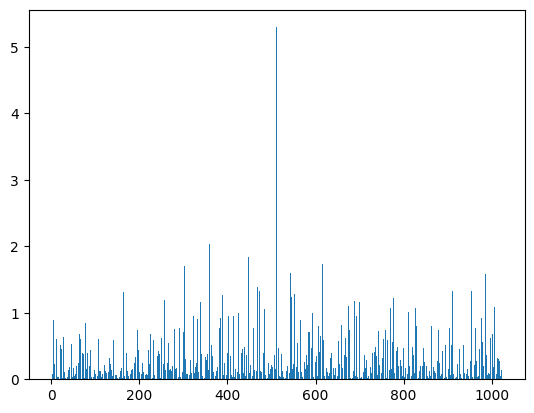

In [ ]:
plt.bar(x = np.arange(0,1024), height = pred[0])

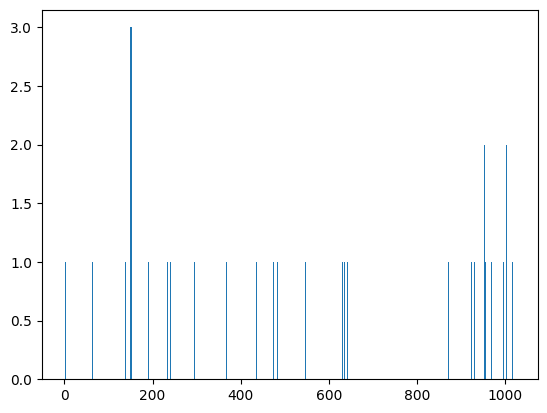

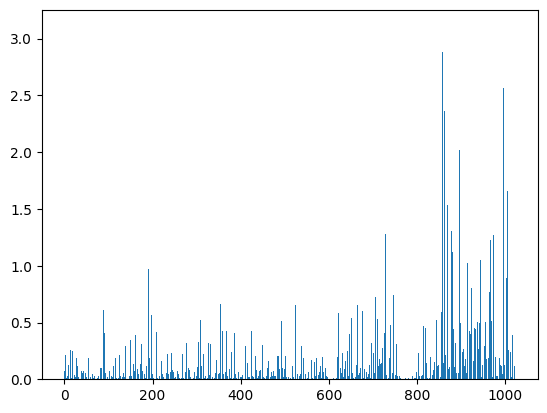

In [ ]:
plt.bar(x = np.arange(0,1024), height = true.iloc[1,0])
plt.show()
plt.bar(x = np.arange(0,1024), height = pred[1])
plt.show()

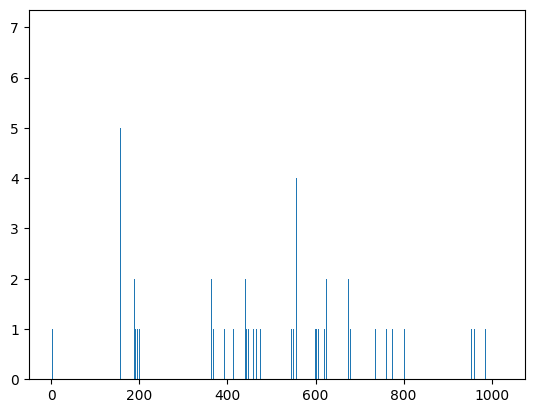

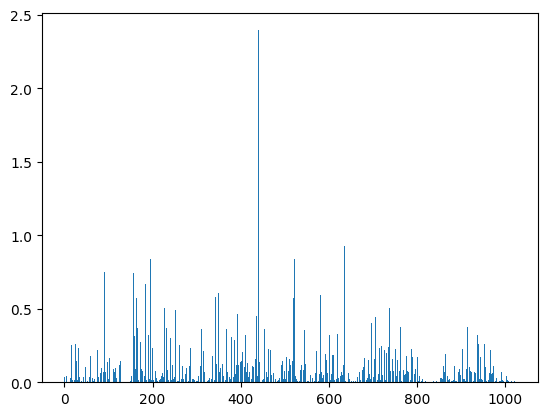

In [ ]:
plt.bar(x = np.arange(0,1024), height = true.iloc[2,0])
plt.show()
plt.bar(x = np.arange(0,1024), height = pred[2])
plt.show()

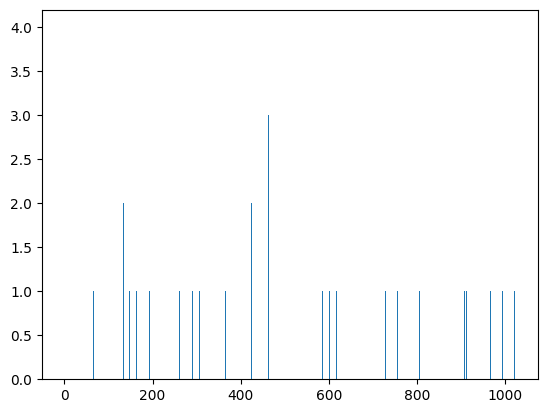

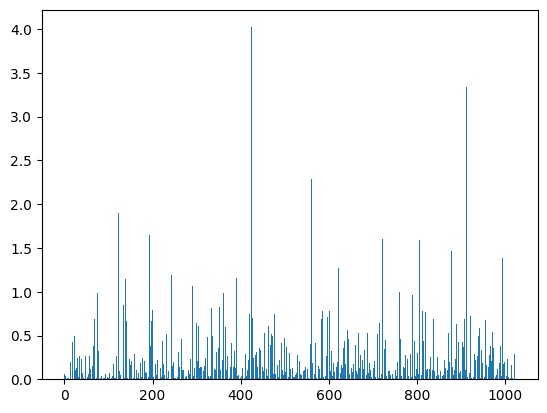

In [ ]:
plt.bar(x = np.arange(0,1024), height = true.iloc[3,0])
plt.show()
plt.bar(x = np.arange(0,1024), height = pred[3])
plt.show()

# Test new model

In [67]:
from models.models import CATAC2
import torch

model  = CATAC2()
input = torch.randn(32, 11, 4096)
 
_, profile, count = model(input)

len(profile)

4

In [1]:
%load_ext autoreload
%autoreload 2

In [265]:
from models.pytorch_datasets import PeaksDataset2
from torch.utils.data import DataLoader

data_dir = "../results/"
time_order = ['D8', 'D12', 'D20', 'D22-15']
chr_test = ['6','13','22']

test_dataset = PeaksDataset2(data_dir + 'peaks_seqtest.pkl', data_dir + 'background_GC_matchedt.pkl',
                                 data_dir + 'ATAC_peakstest.pkl', data_dir + 'ATAC_backgroundtest.pkl', 
                                 chr_test, time_order, 0)
test_dataloader = DataLoader(test_dataset, 5,
                        shuffle=True, num_workers=0)                                

/Users/adorman/Documents/master-thesis/src/models/pytorch_datasets.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.sequences = pd.concat([self.sequences, pickle.load(file).sample(nb_back)])


In [266]:
test_dataset.unique_c_type

array(['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite'], dtype=object)

In [120]:
import numpy as np
np.unique(test_dataset.time, return_counts=True)

(array(['D12', 'D20', 'D8'], dtype=object), array([18, 63, 36]))

In [121]:
from models.eval_metrics import ATACloss_KLD

weight_MSE, weight_KLD = 1, 1
criterion = ATACloss_KLD(weight_MSE= weight_MSE, weight_KLD = weight_KLD)
    
for data in test_dataloader:
    input, tracks, indexes = data
    indexes = torch.stack(indexes)

    _, profile, count = model(input)

    #Compute loss for each head
    losses = [criterion(tracks[:,j,:], profile[j], count[j], indexes[j,:]) for j in range(0,len(profile))]
    KLD = torch.stack([loss[1] for loss in losses]).detach();  MSE = torch.stack([loss[2] for loss in losses]).detach()
    loss = torch.stack([loss[0] for loss in losses]).nansum()

    break

# divers

In [228]:
import h5py

chr = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','X','Y']
chr = ["chr" + x for x in chr] 

dictionary = {}
with h5py.File("../results/hg38Tn5Bias.h5", "r") as f:
    for key in f.keys():

        if key in chr:
            ds_arr = f[key][()] 
            dictionary[key] = ds_arr

dictionary["chr1"][10000:10100]

array([4.29590791e-01, 2.21256065e+00, 7.72537738e-02, 2.23639850e-02,
       2.11469810e-02, 5.72008044e-02, 2.60251307e+00, 6.29612017e+00,
       1.40654072e-01, 2.55845468e-02, 2.69870367e-02, 4.73592103e-01,
       3.85945106e+00, 6.59393978e+00, 1.21274255e-01, 1.91201400e-02,
       2.77483705e-02, 2.34968334e-01, 3.61620951e+00, 4.90611601e+00,
       6.66442886e-02, 1.43714901e-02, 2.70562116e-02, 2.59137571e-01,
       3.42603993e+00, 5.50255013e+00, 5.67826331e-02, 1.07644629e-02,
       2.09104046e-02, 1.75254405e-01, 3.10941505e+00, 5.63720798e+00,
       5.69545031e-02, 7.66042061e-03, 1.51968896e-02, 1.62837222e-01,
       3.02614617e+00, 6.05816269e+00, 5.15529960e-02, 6.44548982e-03,
       1.44752804e-02, 9.65457112e-02, 2.43041110e+00, 6.16991806e+00,
       4.50880229e-02, 4.49537672e-03, 8.82317685e-03, 8.58484358e-02,
       2.45793653e+00, 6.10708714e+00, 3.84801105e-02, 2.54193693e-03,
       8.44881311e-03, 8.62396657e-02, 2.53024316e+00, 6.26629686e+00,
      

In [244]:
def dict_to_bedgraph(data_dict, output_file):
    with open(output_file, 'w') as f:
        for chrom, counts in data_dict.items():

            for pos, count in enumerate(counts):
                if count > 0:
                    f.write(f"{chrom}\t{pos}\t{pos+1}\t{count}\n")

                if pos > 200000:
                    break
            break

dict_to_bedgraph(dictionary, "../results/Tn5_pred.bedgraph")

In [232]:
import pickle
import re

with open('../results/ATAC_peakstest.pkl', 'rb') as file:
    tracks = pickle.load(file)

tracks["c_type"] = [re.findall('[A-Z][^A-Z]*', x) for x in tracks.pseudo_bulk]
tracks["time"] = [x[0] for x in tracks.c_type]; tracks.c_type = [x[1] for x in tracks.c_type]

tracks

,0,pseudo_bulk,c_type,time
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Somite,Somite,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Neuronal,Neuronal,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",D20Mesenchymal,Mesenchymal,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Neuroblast,Neuroblast,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Immature,Immature,D20
...,...,...,...,...
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",D22-15Mesenchymal,Mesenchymal,D22-15
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D22-15Neuroblast,Neuroblast,D22-15
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D22-15Immature,Immature,D22-15
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D22-15Myogenic,Myogenic,D22-15


In [233]:
np.unique(tracks.pseudo_bulk)

array(['D12Immature', 'D12Mesenchymal', 'D12Myoblast', 'D12Myogenic',
       'D12Neuroblast', 'D12Neuronal', 'D12Somite', 'D20Immature',
       'D20Mesenchymal', 'D20Myoblast', 'D20Myogenic', 'D20Neuroblast',
       'D20Neuronal', 'D20Somite', 'D22-15Immature', 'D22-15Mesenchymal',
       'D22-15Myoblast', 'D22-15Myogenic', 'D22-15Neuroblast',
       'D22-15Neuronal', 'D22-15Somite', 'D8Mesenchymal', 'D8Myogenic',
       'D8Neuronal', 'D8Somite'], dtype=object)

In [224]:
np.unique(tracks.c_type)

array(['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite'], dtype=object)

In [234]:
np.unique(tracks.time)

array(['D12', 'D20', 'D22-15', 'D8'], dtype=object)

In [ ]:
!python peak_test2.py